In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Necessary Libraries
import matplotlib.pyplot as plt, numpy as np, bitarray
from scipy import signal

##### Global Vars

In [17]:
fs = 48000  # sampling rate
baud = 1200  # symbol rate
Nbits = 256  # number of bits

f0 = 1700 # center frequency
fd = 500 # delta f

Ndisp = 16 ;   #number of bits to display

In [4]:
Ns = fs/baud  # samples per symbol
N = Nbits * Ns # number of samples

In [272]:
SERIF14 = {'fontsize': 14, 'fontweight' : "bold", "fontfamily":"sans-serif"}
ARIAL12 = {'fontsize': 12, "fontfamily":"arial", "fontstyle":"italic"}

##### Functions

In [37]:
def msg_boolSeq(bool_seq):
    return np.tile(bool_seq*2-1,(1,int(Ns))).ravel()

def arr_boolSeq(bit_arr):
    return bitarray.bitarray(bin_seq.ravel().tolist())

In [102]:
def afsk1200(bits, fs=48000):  
    Ns = fs/baud  # samples per symbol
    N = Nbits * Ns # number of samples
    
    M = msg_boolSeq(bits)

    return np.r_[-N/2.0:N/2.0]/N*fs, np.cos(2*np.pi*np.cumsum(f0 + M*fd)/fs)

In [135]:
def avgPS( x, N=256, fs=1):
    M = int(np.floor(len(x)/N))
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return np.r_[-N/2.0:N/2.0]/N*fs, np.mean(abs(X**2),axis=0)

In [8]:
def afsk1200Demod(sig, f_low, f_high, TBW=2.0, N=74,  fs = 48000):
    BW =  float(TBW) / N
    
    h_mark = signal.firwin(numtaps=N, cutoff=BW) * np.exp(1j * 2 * np.pi * f_low/fs * np.arange(N))
    h_space = signal.firwin(numtaps=N, cutoff=BW) * np.exp(1j * 2 * np.pi * f_high/fs * np.arange(N))

    v_space = signal.fftconvolve(sig, h_space)
    v_mark  = signal.fftconvolve(sig, h_mark)

    NRZa = abs(v_space) - abs(v_mark)

    return NRZa[int(N/2):-int(N/2)]

In [233]:
def arr_msgSig(M):
    return bitarray.bitarray([int((np.mean(M[x:x+int(Ns)-1])+1)/2) for x in range(0, len(M), int(Ns))])

In [234]:
def clac_ber(original, noised, num=N):
    return sum([x!=y for x, y in zip(original.tolist(), noised.tolist())]) / num

### Generating the Message Signal

In [206]:
Nbits = 32

Ns = fs/baud  # samples per symbol
N = Nbits * Ns # number of samples

In [207]:
np.random.seed(42)

bin_seq = np.random.randn(Nbits,1) > 0 

msg_sig =  msg_boolSeq(bin_seq)

bits_ref = arr_boolSeq(bin_seq)

In [208]:
bin_seq.ravel()

array([ True, False,  True,  True, False, False,  True,  True, False,
        True, False, False,  True, False, False, False, False,  True,
       False, False,  True, False,  True, False, False,  True, False,
        True, False, False, False,  True])

In [209]:
bits_ref

bitarray('10110011010010000100101001010001')

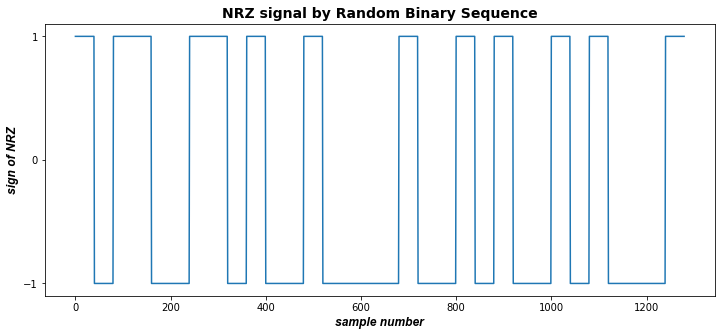

In [210]:
plt.figure(figsize=(12,5))

plt.plot(msg_sig)

plt.title("NRZ signal by Random Binary Sequence", fontdict=SERIF14)
plt.xlabel("sample number" , fontdict=ARIAL12)
plt.ylabel("sign of NRZ", fontdict=ARIAL12)

plt.yticks([1, 0, -1])

plt.show()

### AFSK Modulation

In [211]:
t, FSK = afsk1200(bin_seq)

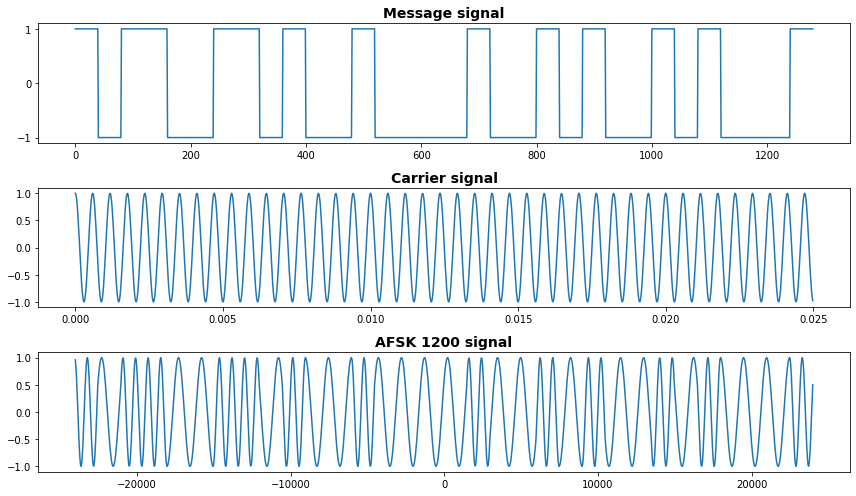

In [212]:
plt.figure(figsize=(12,7))

plt.subplot(311)
plt.plot(msg_sig)
plt.title("Message signal", fontdict=SERIF14)
plt.yticks([1, 0, -1])

plt.subplot(312)
plt.plot(np.arange(0 , .025, 1/fs), np.cos(2*np.pi*f0*np.arange(0 , .025, 1/fs)))
plt.title("Carrier signal", fontdict=SERIF14)

plt.subplot(313)
plt.plot(t, FSK)
plt.title("AFSK 1200 signal", fontdict=SERIF14)

plt.tight_layout()
plt.show()

In [136]:
(f,FSK_f) = avgPS(FSK,512,fs)

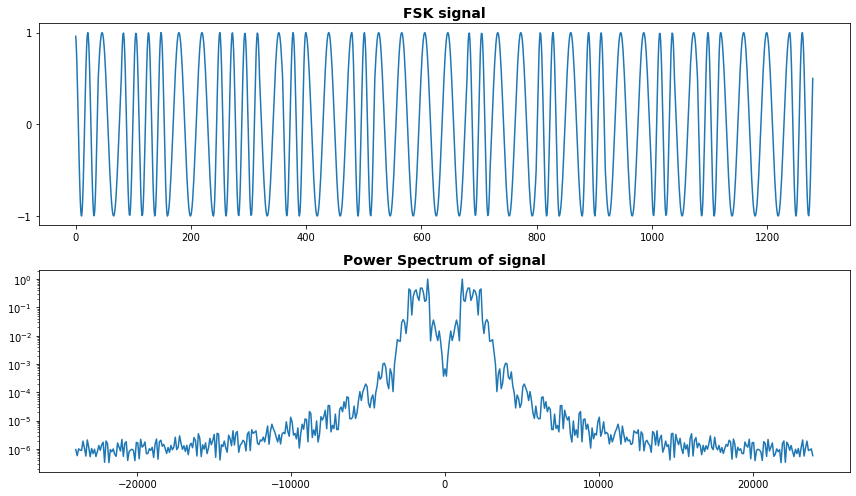

In [204]:
plt.figure(figsize=(12,7))

plt.subplot(211)
plt.plot(FSK)
plt.title("FSK signal", fontdict=SERIF14)
plt.yticks([1, 0, -1])

plt.subplot(212)
plt.semilogy(f,FSK_f/max(FSK_f))
plt.title("Power Spectrum of signal", fontdict=SERIF14)

plt.tight_layout()
plt.show()

#### testing AFSK function

In [178]:
Nbits = 4096
N = Nbits * Ns 

bits_ref = np.random.randn(Nbits,1) > 0  

In [179]:
sig_ref8192 = afsk1200(bits_ref,fs = 8192)[1]
sig_ref11025 = afsk1200(bits_ref,fs = 11025)[1]
sig_ref44100 = afsk1200(bits_ref,fs = 44100)[1]
sig_ref48000 = afsk1200(bits_ref,fs = 48000)[1]
np.savez_compressed('./data/debug_ref.npz', bits=bits_ref, sig_ref8192=sig_ref8192, sig_ref11025 = sig_ref11025,sig_ref44100=sig_ref44100, sig_ref48000=sig_ref48000)

In [180]:
testnpz = np.load("./data/debug_ref.npz")

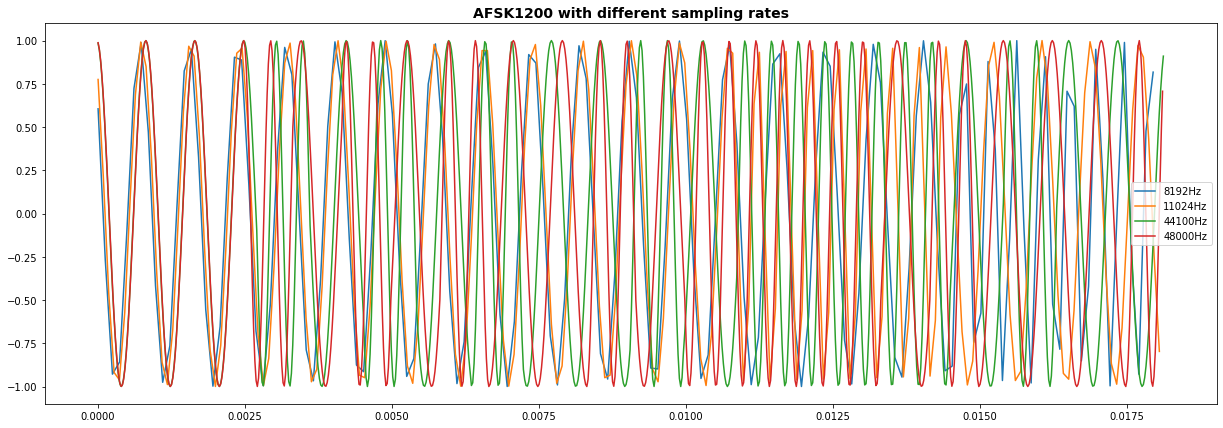

In [181]:
b = bitarray.bitarray()
bits_ref = b.frombytes(testnpz['bits'].tobytes())
sig_ref8192 = testnpz['sig_ref8192']
sig_ref11025 = testnpz['sig_ref11025']
sig_ref44100 = testnpz['sig_ref44100']
sig_ref48000 = testnpz['sig_ref48000']

# Check that all the loaded signals align
plt.figure(figsize=(21, 7))

plt.plot(np.r_[0.0:148]/8192,sig_ref8192[:148])
plt.plot(np.r_[0.0:200]/11025,sig_ref11025[:200])
plt.plot(np.r_[0.0:800]/44100,sig_ref44100[:800])
plt.plot(np.r_[0.0:870]/48000,sig_ref48000[:870])

plt.title('AFSK1200 with different sampling rates', fontdict=SERIF14)
plt.legend(('8192Hz','11024Hz','44100Hz', '48000Hz'))

plt.show()

### AFSK Demodulation

In [213]:
Nbits = 10000
N = Nbits * Ns 

bin_seq = np.random.randn(Nbits,1) > 0  

In [214]:
msg_sig =  msg_boolSeq(bin_seq)

bits_ref = arr_boolSeq(bin_seq)

In [215]:
t, mod = afsk1200(bin_seq)
demod = afsk1200Demod(mod, 1200, 2200, N=99)

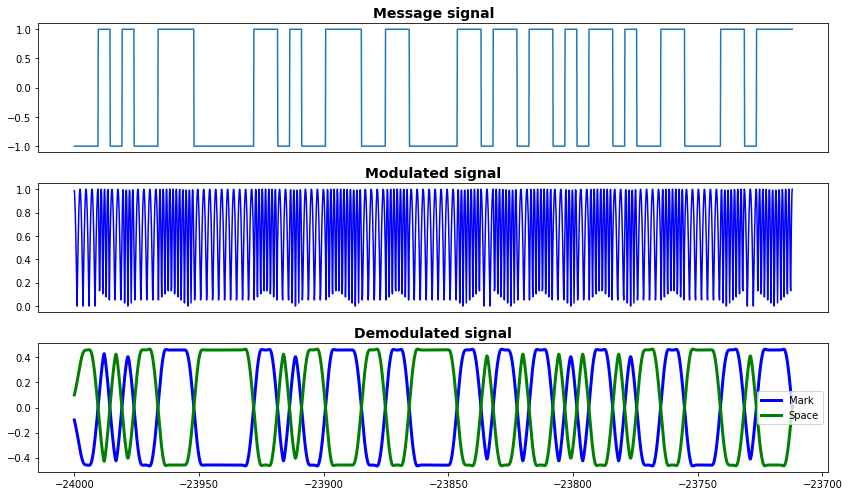

In [229]:
plt.figure(figsize=(12,7))

sampl = 2400

plt.subplot(311)
plt.plot(t[0:sampl],msg_sig[0:sampl])
plt.title("Message signal", fontdict=SERIF14)
plt.xticks([])

plt.subplot(312)
plt.plot(t[0:sampl],np.abs(mod[0:sampl]),'b')
plt.title("Modulated signal", fontdict=SERIF14)
plt.xticks([])

plt.subplot(313)
plt.plot(t[0:sampl], demod[0:sampl],'b-',linewidth=3.0, label="Mark")
plt.plot(t[0:sampl], -demod[0:sampl],'g-',linewidth=3.0, label="Space")
plt.title("Demodulated signal", fontdict=SERIF14)
plt.legend()

plt.tight_layout()
plt.show()

In [217]:
msgD = np.sign(demod)

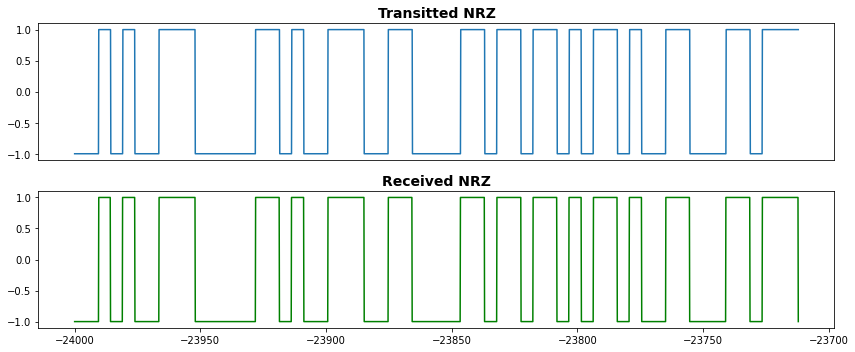

In [230]:
plt.figure(figsize=(12, 5))

sampls = 2400

plt.subplot(211)
plt.plot(t[:sampls], msg_sig[:sampls])
plt.title("Transitted NRZ", fontdict=SERIF14)
plt.xticks([])

plt.subplot(212)
plt.plot(t[:sampls], msgD[:sampls], "g")
plt.title("Received NRZ", fontdict=SERIF14)

plt.tight_layout()
plt.show()

In [235]:
arr_msgSig(msgD)[:10]

bitarray('0010100111')

In [232]:
bits_ref[:10]

bitarray('0010100111')

In [236]:
arr_msgSig(msgD) == bits_ref

True

### Bit Erro Rate

In [237]:
Nbits = 10000

Ns = fs/baud  # samples per symbol
N = Nbits * Ns # number of samples

In [238]:
bin_seq = np.random.randn(Nbits,1) > 0 

msg_sig =  msg_boolSeq(bin_seq)

bits_ref = arr_boolSeq(bin_seq)

In [240]:
t, fsk_sig = afsk1200(bin_seq)

In [241]:
mu, sigma = 0, 1 
noise = sigma * np.random.randn(fsk_sig.shape[0]) + mu

fsk_noised = fsk_sig + noise

In [242]:
demod = afsk1200Demod(fsk_sig, 1200, 2200, N=99)
demod2 = afsk1200Demod(fsk_noised, 1200, 2200, N=99)

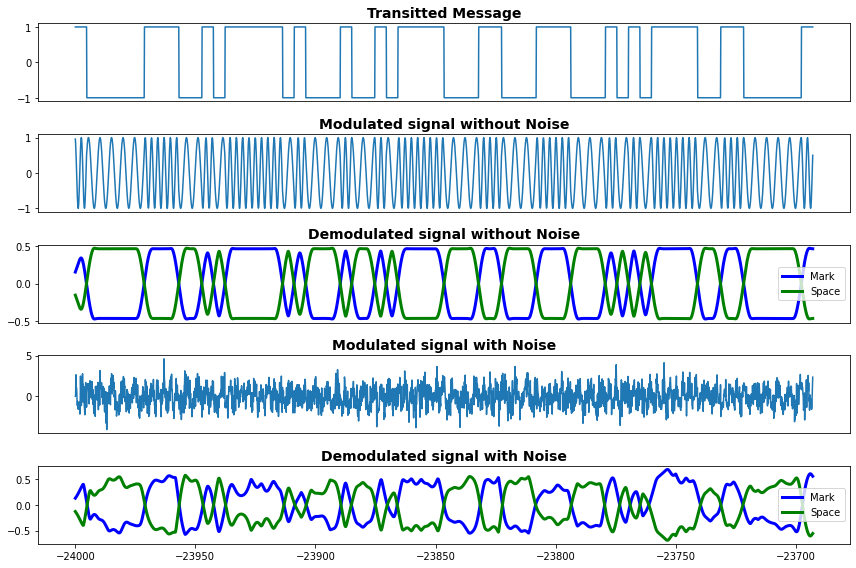

In [249]:
plt.figure(figsize=(12, 8))

sampls = 2560

plt.subplot(511)
plt.plot(t[:sampls], msg_sig[:sampls])
plt.title("Transitted Message", fontdict=SERIF14)
plt.xticks([])

plt.subplot(512)
plt.plot(t[:sampls], fsk_sig[:sampls])
plt.title("Modulated signal without Noise", fontdict=SERIF14)
plt.xticks([])

plt.subplot(513)
plt.plot(t[0:sampls],demod[0:sampls],'b-',linewidth=3.0, label="Mark")
plt.plot(t[0:sampls],-demod[0:sampls],'g-',linewidth=3.0, label="Space")
plt.title("Demodulated signal without Noise", fontdict=SERIF14)
plt.xticks([])
plt.legend()

plt.subplot(514)
plt.plot(t[:sampls], fsk_noised[:sampls])
plt.title("Modulated signal with Noise", fontdict=SERIF14)
plt.xticks([])

plt.subplot(515)
plt.plot(t[0:sampls],demod2[0:sampls],'b-',linewidth=3.0, label="Mark")
plt.plot(t[0:sampls],-demod2[0:sampls],'g-',linewidth=3.0, label="Space")
plt.title("Demodulated signal with Noise", fontdict=SERIF14)
plt.legend()

plt.tight_layout()
plt.show()

In [250]:
sampls = 2560

t_stem = [np.median(t[:sampls][x:x+int(Ns/2)])  for x in range(0, len(t[:sampls]), int(Ns/2))]

demod_stem = [np.median(demod2[:sampls][x:x+int(Ns/2)])  for x in range(0, len(demod2[:sampls]), int(Ns/2))]

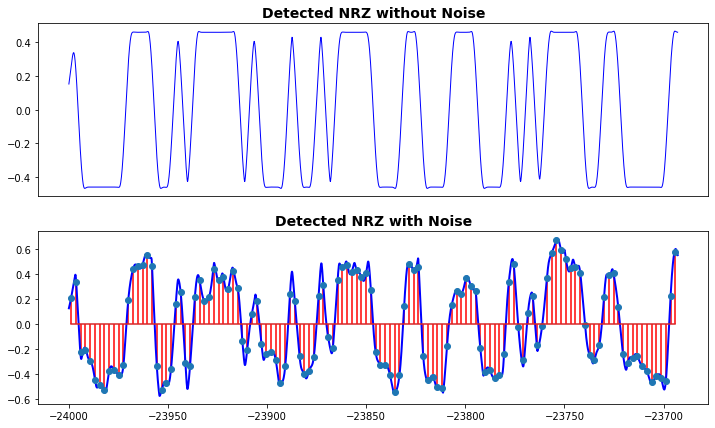

In [260]:
plt.figure(figsize=(12, 7))

plt.subplot(211)
plt.plot(t[0:sampls],demod[0:sampls], "b", linewidth=1.0)
plt.title("Detected NRZ without Noise", fontdict=SERIF14)
plt.xticks([])

plt.subplot(212)
plt.plot(t[0:sampls],demod2[0:sampls],'b',linewidth=2.0)
plt.stem(t_stem, demod_stem, "r")
plt.title("Detected NRZ with Noise", fontdict=SERIF14)

plt.show()

In [261]:
msgD = np.sign(demod2)
bitsD = arr_msgSig(msgD)

clac_ber(bits_ref, bitsD, Nbits)

0.1822

#### BER Curves

In [262]:
BER_nc = []

for s in np.r_[0.1:8.0:0.1]:    
    mu, sigma = 0, round(s,1)
    noise = sigma * np.random.randn(fsk_sig.shape[0]) + mu

    fsk_noised = fsk_sig + noise
    fsk_demod = afsk1200Demod(fsk_noised, 1200, 2200, N=99)
    
    msgD = np.sign(fsk_demod)
    bitsD = arr_msgSig(msgD)
    
    BER_nc.append(clac_ber(bits_ref, bitsD, Nbits))

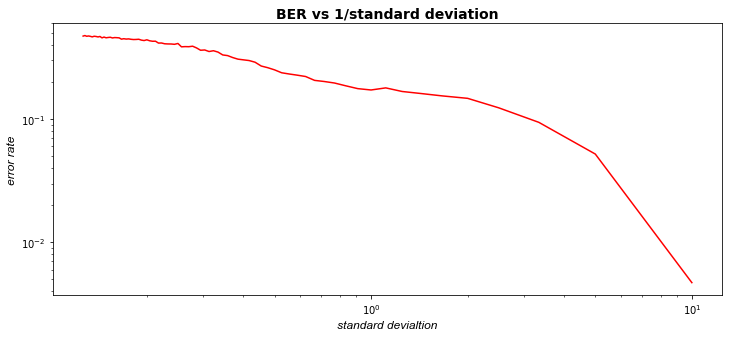

In [273]:
plt.figure(figsize=(12,5))

plt.loglog(1/(np.r_[0.1:8.0:0.1]),BER_nc, "r")
plt.title("BER vs 1/standard deviation", fontdict=SERIF14)
plt.xlabel("standard devialtion", fontdict=ARIAL12)
plt.ylabel("error rate", fontdict=ARIAL12)

plt.show()